In [1335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import talib as ta
from talib import abstract
import yfinance as yfin
from arch import arch_model

pd.set_option('display.float_format', '{:.2f}'.format)


In [1336]:
# data_path = '/Users/xinc./Documents/GitHub/Quant_idea/data/0804 大社課 TXF 1m.csv'
# df = pd.read_csv(data_path)
# df.index = pd.to_datetime(df['datetime'])
# df = df.drop(columns = ['Unnamed: 0', 'datetime', 'Date', 'Time'])
# df.columns = ['open', 'high', 'low', 'close', 'volume']

df = yfin.download('^TWII', start = '2022-1-1', end = '2022-11-30')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
# 計算資料DataFrame
ret_df = pd.DataFrame(index = df.index)
# 績效DataFrame
equity = pd.DataFrame()


[*********************100%%**********************]  1 of 1 completed


In [1337]:
# parameters
data = df['close']
a = 0.9
num_vol = 1
rolling = 20
upper_threshold = 0.03
lower_threshold = 0.1
retrace_u_threshold = 0.05
retrace_l_threshold = 0.05
df['llt_slope'] = np.nan

def llt(data, a):
    llt = np.zeros(len(data))
    llt[0] = data[0]
    llt[1] = (1 - a) * data[0] + a * data[1]
    for n in range(2, len(data)):
        llt[n] = ((a - (a ** 2)/4) * data[n]) + (((a ** 2)/2) * data[n - 1]) - ((a - (3 * (a ** 2))/4) * data[n - 2]) + ((2 * (1 - a)) * llt[n - 1]) - (((1 - a) ** 2) * llt[n - 2])
    return llt

df['llt'] = llt(data, a)

for i in range(1, len(df)):
    df['llt_slope'][i] = df['llt'][i] - df['llt'][i - 1]

def bolinger_band(data, num_vol):
    model = arch_model(df['llt'].dropna(), vol = 'Garch', p = 1, q = 1)
    garch_fit = model.fit(disp = 'off')
    df['garch_volitility'] = garch_fit.conditional_volatility

    df['bolinger_upper'] = df['llt'] + num_vol * df['garch_volitility']
    df['bolinger_lower'] = df['llt'] - num_vol * df['garch_volitility']

    df['upper_max'] = df['bolinger_upper'].rolling(window = rolling).max()
    df['lower_min'] = df['bolinger_lower'].rolling(window = rolling).min()

    df['bolinger_upper_max'] = df['bolinger_upper'].cummax()
    df['bolinger_lower_min'] = df['bolinger_lower'].cummin()

    df['upper_retrace'] = (df['bolinger_upper_max'] - df['bolinger_upper']) / df['bolinger_upper_max']
    df['lower_rise'] = (df['bolinger_lower'] - df['bolinger_lower_min']) / df['bolinger_lower_min']

    df['upper_deviation'] = (df['bolinger_upper'] - df['close']) / df['close']
    df['lower_deviation'] = (df['close'] - df['bolinger_lower']) / df['close']

    df['upper_exceed'] = df['upper_deviation'] > upper_threshold
    df['lower_exceed'] = df['lower_deviation'] > lower_threshold
    
    df['take_profit'] = df['upper_retrace'] >= retrace_u_threshold
    df['stop_loss'] = df['lower_rise'] >= retrace_l_threshold
    return df

df = bolinger_band(data, num_vol)



/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/307073118.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  llt[0] = data[0]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/307073118.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  llt[1] = (1 - a) * data[0] + a * data[1]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/307073118.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

In [1338]:
'''long only'''
'''
停利停損條件
通道收斂
'''

'\n停利停損條件\n通道收斂\n'

In [1339]:
# strategy
BS = None
fund = 1000000
feePaid = 600
ret_df['position'] = 0
ret_df['buy_price'] = 0
ret_df['sell_price'] = 0
ret_df['buy'] = 0
ret_df['sell'] = 0
ret_df['profit_list'] = np.zeros(len(df))
ret_df['profit_fee_list'] = np.zeros(len(df))
ret_df['profit_fee_list_realized'] = np.zeros(len(df))
cost_list = []

for i in range(2, len(df)):
    if i == len(df) - 1:
        break
    
    ## 進場邏輯
    entryLong = (df['llt_slope'][i] > 0) & (df['upper_exceed'][i] == True)

    ##出場邏輯
    exitLong = (df['llt_slope'][i] < 0) & ((df['take_profit'][i] == True) or (df['stop_loss'][i] == True))


    if BS == None:
        if entryLong:
            BS = 'B'
            t = i + 1
            ret_df['buy'].iloc[t] = t
            ret_df['buy_price'].iloc[t] = df['open'].iloc[t]
            ret_df['position'].iloc[t] += 1
            print(f"Buy signal at index {t}, buy price: {df['open'].iloc[t]}")
    elif BS == 'B':
        ret_df['position'].iloc[i + 1] = ret_df['position'].iloc[i]
        profit = 200 *(df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
        ret_df['profit_list'].iloc[i + 1] = profit

        if exitLong or i == len(df) - 2:
            pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t])
            profit_fee = profit - feePaid * 2
            ret_df['profit_fee_list'].iloc[i + 1] = profit_fee
            ret_df['sell_price'].iloc[i + 1] = df['open'].iloc[i + 1]
            ret_df['sell'].iloc[i + 1] = i + 1

            BS = None
            print(f"Sell signal at index {i+1}, sell price: {df['open'].iloc[i + 1]}, profit: {pl_round - feePaid * 2}")

            ret_df['profit_fee_list_realized'].iloc[i + 1] = pl_round - feePaid * 2

        else:
            profit_fee = profit
            ret_df['profit_fee_list'].iloc[i + 1] = profit_fee

df['strategy_ret'] = ret_df['profit_list'].cumsum()
equity['profitfee'] = ret_df['profit_fee_list'].cumsum()

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/3028802410.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entryLong = (df['llt_slope'][i] > 0) & (df['upper_exceed'][i] == True)
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/3028802410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exitLong = (df['llt_slope'][i] < 0) & ((df['take_profit'][i] == True) or (df['stop_loss'][i] == True))
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/3028802410.py:30: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through ch

Buy signal at index 3, buy price: 18395.720703125
Sell signal at index 16, sell price: 17890.7109375, profit: -102201.953125
Buy signal at index 19, buy price: 17955.94921875
Sell signal at index 32, sell price: 17617.359375, profit: -68917.96875
Buy signal at index 34, buy price: 17864.109375
Sell signal at index 36, sell price: 17845.009765625, profit: -5019.921875
Buy signal at index 40, buy price: 17224.73046875
Sell signal at index 43, sell price: 17177.26953125, profit: -10692.1875
Buy signal at index 46, buy price: 17439.91015625
Sell signal at index 48, sell price: 17512.41015625, profit: 13300.0
Buy signal at index 49, buy price: 17581.619140625
Sell signal at index 52, sell price: 17510.150390625, profit: -15493.75
Buy signal at index 55, buy price: 17754.099609375
Sell signal at index 57, sell price: 17484.189453125, profit: -55182.03125
Buy signal at index 63, buy price: 17353.25
Sell signal at index 65, sell price: 16958.66015625, profit: -80117.96875
Buy signal at index 6

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/3028802410.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret_df['profit_fee_list'].iloc[i + 1] = profit_fee
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/3028802410.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entryLong = (df['llt_slope'][i] > 0) & (df['upper_exceed'][i] == True)
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/3028802410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

In [1340]:
ret_df['index_ret'] = np.zeros(len(df))

for i in range(1, len(df)):
    ret_df['index_ret'].iloc[i] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200

ret_df['cum_index_ret'] = ret_df['index_ret'].cumsum()

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/3050492744.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ret_df['index_ret'].iloc[i] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200
/var/folders/0j/sdf7gd116kd5lv1

In [1341]:
ret_df

,position,buy_price,sell_price,buy,sell,profit_list,profit_fee_list,profit_fee_list_realized,index_ret,cum_index_ret
Date,,,,,,,,,,
2022-01-03,0,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00
2022-01-04,0,0.00,0.00,0,0,0.00,0.00,0.00,26982.03,26982.03
2022-01-05,0,0.00,0.00,0,0,0.00,0.00,0.00,40598.05,67580.08
2022-01-06,1,18395.72,0.00,3,0,0.00,0.00,0.00,-40482.03,27098.05
2022-01-07,1,0.00,0.00,0,0,-1512.11,-1512.11,0.00,-1512.11,25585.94
...,...,...,...,...,...,...,...,...,...,...
2022-11-23,0,0.00,0.00,0,0,0.00,0.00,0.00,38283.98,-732946.09
2022-11-24,0,0.00,0.00,0,0,0.00,0.00,0.00,10859.96,-722086.13
2022-11-25,0,0.00,0.00,0,0,0.00,0.00,0.00,23028.12,-699058.01


In [1342]:
# performance
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(ret_df[ret_df['buy'] > 0]) + len(ret_df[ret_df['sell'] >  0])
winRate = len([i for i in ret_df['profit_fee_list_realized'] if i > 0]) / len(ret_df['profit_fee_list_realized'])
profitFactor = sum([i for i in ret_df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in ret_df['profit_fee_list_realized'] if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

Profit :  -305769.140625
Return :  -0.30576914062500005
Max DrawDown :  0.6057225268474873
Caimar Ratio :  -0.5048006753461698
Trade Times :  60
Win Rate :  0.04484304932735426
Profit Factor :  0.6515361418697598


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_50608/2835976740.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


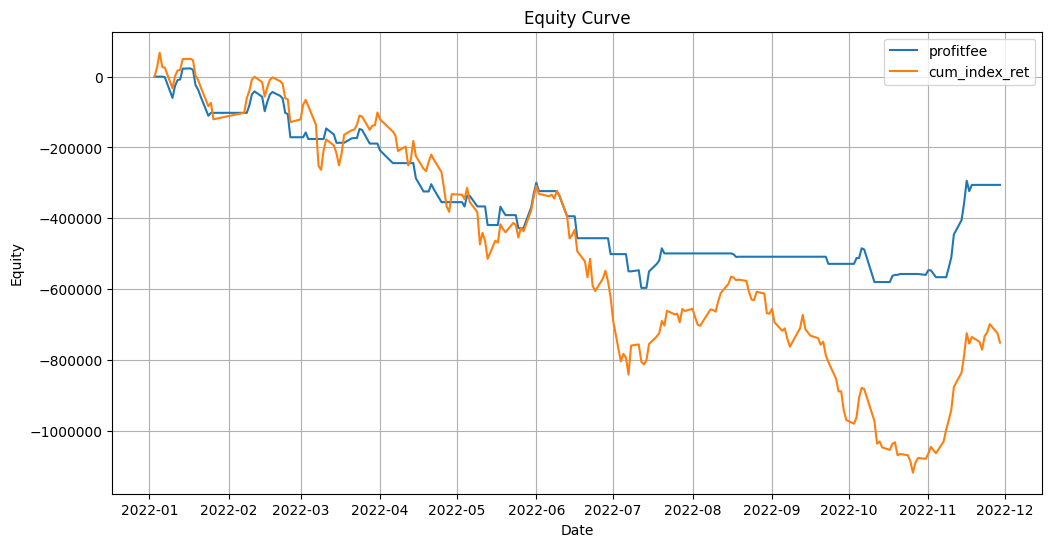

In [1343]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, equity['profitfee'], label='profitfee')
ax.plot(df.index, ret_df['cum_index_ret'], label='cum_index_ret')

## 设置纵轴刻度格式
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

## 添加网格、标签和标题
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.set_title('Equity Curve')
ax.legend()

plt.show()


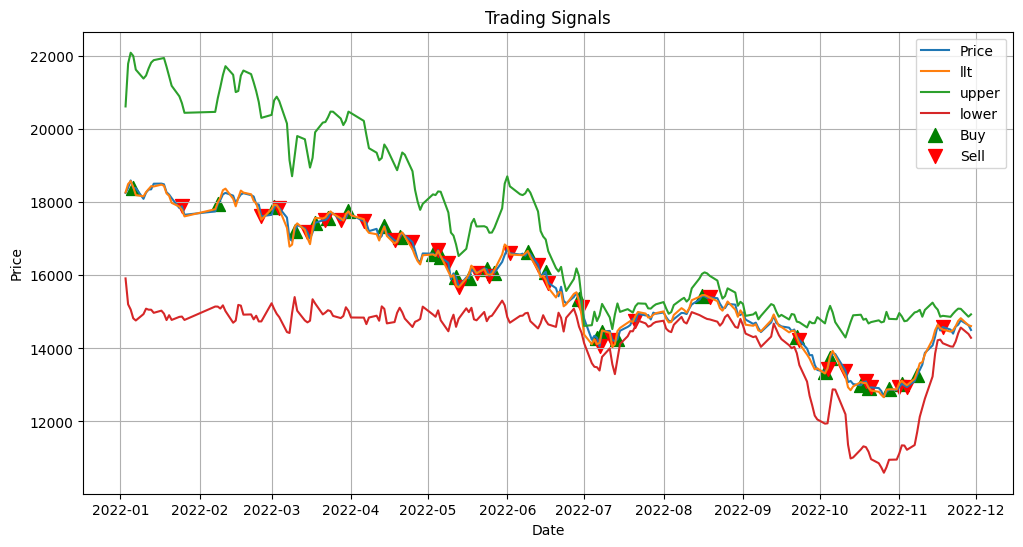

In [1344]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[['open', 'llt', 'bolinger_upper', 'bolinger_lower']], label=['Price', 'llt', 'upper', 'lower'])

# 标记买入点
buy_signals = ret_df[ret_df['buy'] != 0]
plt.scatter(buy_signals.index, buy_signals['buy_price'], marker='^', color='g', label='Buy', s=100)

# 标记卖出点
sell_signals = ret_df[ret_df['sell'] != 0]
plt.scatter(sell_signals.index, sell_signals['sell_price'], marker='v', color='r', label='Sell', s=100)

# 添加图例和标题
plt.legend()
plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [1345]:
tdf = pd.DataFrame()
tdf['open'] = df['open']
tdf['buy_price'] = ret_df['buy_price']
tdf['sell_price'] = ret_df['sell_price']
tdf['profit_list'] = ret_df['profit_list']
tdf['position'] = ret_df['position']
tdf[:20]

,open,buy_price,sell_price,profit_list,position
Date,,,,,
2022-01-03,18260.23,0.00,0.00,0.00,0
2022-01-04,18395.14,0.00,0.00,0.00,0
2022-01-05,18598.13,0.00,0.00,0.00,0
2022-01-06,18395.72,18395.72,0.00,0.00,1
2022-01-07,18388.16,0.00,0.00,-1512.11,1
2022-01-10,18095.39,0.00,0.00,-58553.91,1
2022-01-11,18266.54,0.00,0.00,34229.69,1
2022-01-12,18348.39,0.00,0.00,16370.31,1
2022-01-13,18356.21,0.00,0.00,1564.06,1
